COMP 534 Assignment 3

Imported Packages/ Libraries

In [137]:
import pandas as pd                                      # Import pandas for data manipulation
import numpy as np                                       # Import numpy for numerical operations
import seaborn as sns                                    # Import seaborn for data visualization
import matplotlib.pyplot as plt                          # Import matplotlib for plotting
from sklearn.model_selection import train_test_split     # Import train_test_split for splitting data
from sklearn.model_selection import cross_validate, cross_val_score  # Import cross-validation methods 
from sklearn.model_selection import GridSearchCV         # Import GridSearchCV for hyperparameter tuning
from sklearn.decomposition import PCA                    # Import PCA for dimensionality reduction
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from collections import Counter
from scipy.stats import mode
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix # Import confusion matrix and classification report
from imblearn.over_sampling import SMOTE
from skorch import NeuralNetClassifier # Define skorch wrapper for the model


Load the dataset and Print the Data Information

In [82]:
# Read the CSV file into a DataFrame
data = pd.read_csv('stars_data.csv')

# Display the first 5 rows of the DataFrame
print("First 5 rows of the data:")
print(data.head(5))

# Print information about the data
print("Data Information:")
print(data.info())


First 5 rows of the data:
   Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
0             3068          0.002400        0.1700                   16.12   
1             3042          0.000500        0.1542                   16.60   
2             2600          0.000300        0.1020                   18.70   
3             2800          0.000200        0.1600                   16.65   
4             1939          0.000138        0.1030                   20.06   

   Star type Star color Spectral Class  
0          0        Red              M  
1          0        Red              M  
2          0        Red              M  
3          0        Red              M  
4          0        Red              M  
Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         24

Print out the Number of Samples for each Class

In [83]:
# Count the number of samples for each class in the 'class' column
class_counts = data['Spectral Class'].value_counts()

# Print the number of samples for each class
print("Number of samples for each class:")
print(class_counts)


Number of samples for each class:
Spectral Class
M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: count, dtype: int64


Visualize the Data

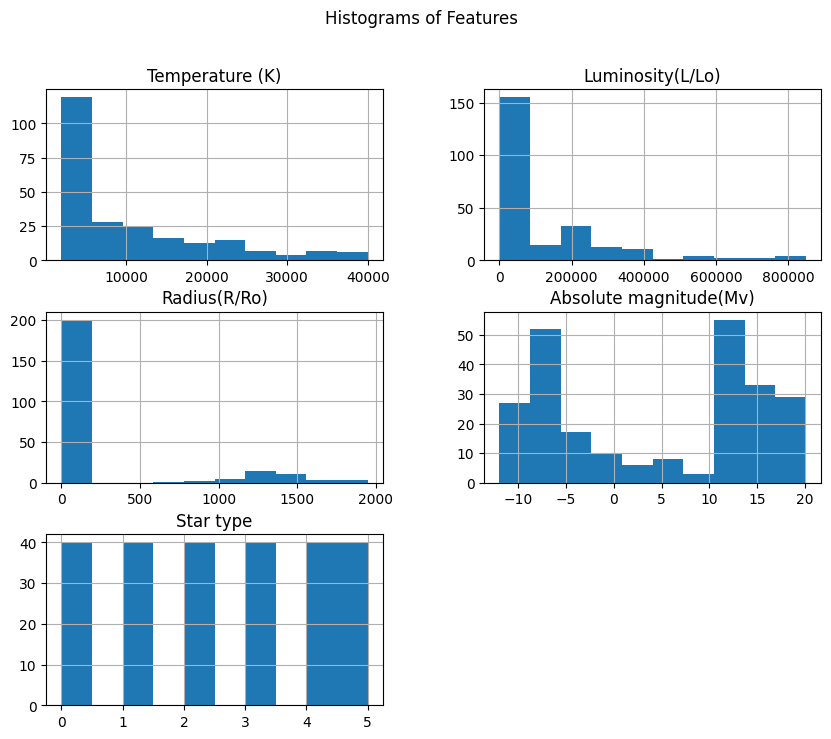

<Figure size 1000x800 with 0 Axes>

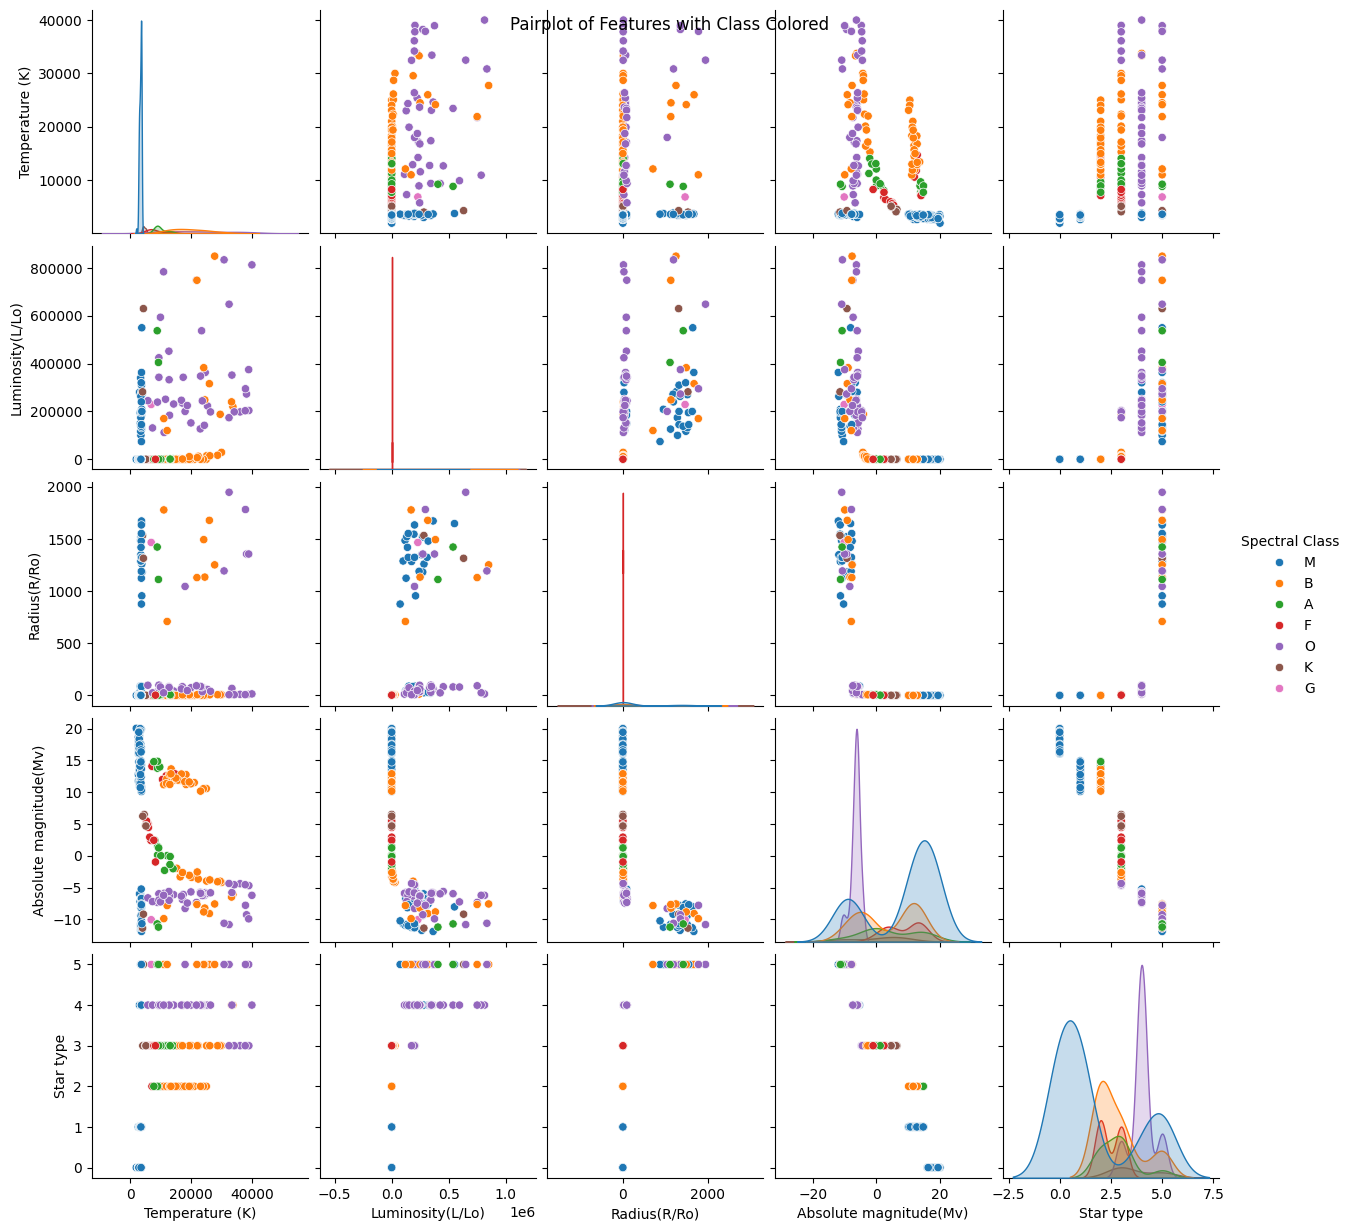

In [85]:
# Histograms
data.hist(figsize=(10, 8))
plt.suptitle("Histograms of Features")
plt.show()

# Scatter plots (pairplot)
plt.figure(figsize=(10, 8))
sns.pairplot(data=data, hue='Spectral Class')
plt.suptitle("Pairplot of Features with Class Colored")
plt.show()

Split Dataset into Training and Test Dataset (80% vs 20%)

In [143]:
# Remove class 'G' (with only one sample)
data = data[data['Spectral Class'] != 'G']

# Encode categorical features
label_encoder_color = LabelEncoder()
label_encoder_spectral = LabelEncoder()
data['Star color'] = label_encoder_color.fit_transform(data['Star color'])
data['Spectral Class'] = label_encoder_spectral.fit_transform(data['Spectral Class'])

# Separate features and labels
X = data.drop('Spectral Class', axis=1)
y = data['Spectral Class']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform stratified sampling to split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


# Check the distribution in training and testing sets
print("Training set class distribution:")
print(y_train.value_counts())
print("\nTesting set class distribution:")
print(y_test.value_counts())

Training set class distribution:
Spectral Class
4    89
1    37
5    32
0    15
2    13
3     5
Name: count, dtype: int64

Testing set class distribution:
Spectral Class
4    22
1     9
5     8
2     4
0     4
3     1
Name: count, dtype: int64


Random Forest Classifier

Random Forest Accuracy: 0.9583333333333334
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.89      0.94         9
           2       1.00      0.75      0.86         4
           3       0.50      1.00      0.67         1
           4       1.00      1.00      1.00        22
           5       0.89      1.00      0.94         8

    accuracy                           0.96        48
   macro avg       0.90      0.94      0.90        48
weighted avg       0.97      0.96      0.96        48



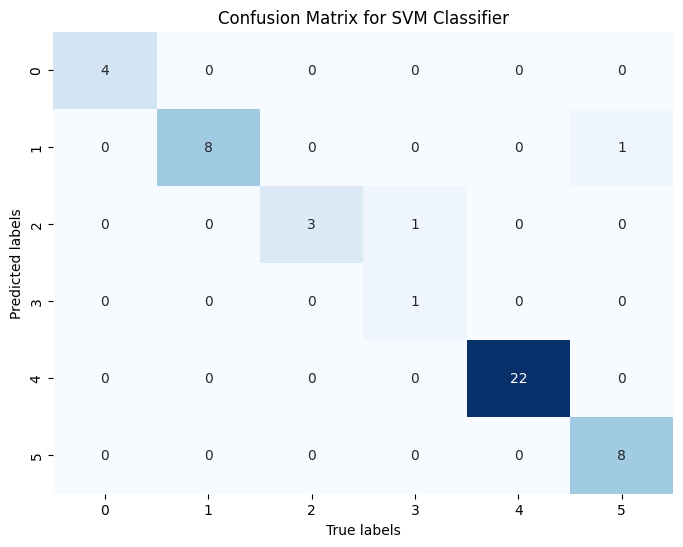

In [145]:
# Train a Random Forest model with class weights
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# Predictions on the test set
y_pred_rf = rf.predict(X_test)

# Evaluation
print('Random Forest Accuracy:', accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.title('Confusion Matrix for SVM Classifier')
plt.show()

Hyperparameter Tuning for Random Forest

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Accuracy (post-tuning): 0.9583333333333334
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.89      0.94         9
           2       1.00      0.75      0.86         4
           3       0.50      1.00      0.67         1
           4       1.00      1.00      1.00        22
           5       0.89      1.00      0.94         8

    accuracy                           0.96        48
   macro avg       0.90      0.94      0.90        48
weighted avg       0.97      0.96      0.96        48



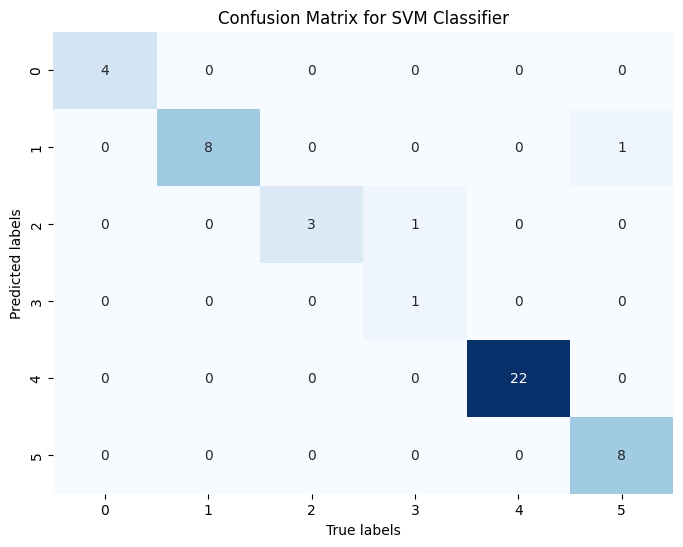

In [146]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(rf, param_grid_rf, refit=True, verbose=2, cv=5, n_jobs=-1)

# Fit GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Best parameters found by GridSearchCV
print("Best parameters found: ", grid_search_rf.best_params_)

# Best estimator
best_rf = grid_search_rf.best_estimator_

# Predictions on the test set using the best estimator
y_pred_best_rf = best_rf.predict(X_test)

# Evaluation
print('Random Forest Accuracy (post-tuning):', accuracy_score(y_test, y_pred_best_rf))
print(classification_report(y_test, y_pred_best_rf))
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_best_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.title('Confusion Matrix for SVM Classifier')
plt.show()


UnSupervised Classification- KMeans Clustering

In [95]:

# Apply KMeans with the number of classes as the number of clusters
n_classes = len(np.unique(y))
kmeans = KMeans(n_clusters=n_classes, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(X_scaled)

# Get cluster labels
cluster_labels = kmeans.labels_

# Map clusters to true labels
def map_clusters_to_labels(cluster_labels, true_labels):
    label_mapping = {}
    for cluster in np.unique(cluster_labels):
        mask = (cluster_labels == cluster)
        common_label = Counter(true_labels[mask]).most_common(1)[0][0]
        label_mapping[cluster] = common_label
    return np.array([label_mapping[cluster] for cluster in cluster_labels])

# Map cluster labels to true labels
y_pred = map_clusters_to_labels(cluster_labels, y)

# Calculate evaluation metrics
accuracy = accuracy_score(y, y_pred)

print(f'Accuracy: {accuracy:.4f}')

# Detailed classification report
print(classification_report(y, y_pred, target_names=label_encoder_spectral.classes_))


Accuracy: 0.7908
              precision    recall  f1-score   support

           A       0.00      0.00      0.00        19
           B       0.74      0.76      0.75        46
           F       0.43      0.71      0.53        17
           K       0.00      0.00      0.00         6
           M       0.88      0.92      0.90       111
           O       0.83      1.00      0.91        40

    accuracy                           0.79       239
   macro avg       0.48      0.56      0.52       239
weighted avg       0.72      0.79      0.75       239



C:\Users\akino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\akino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\akino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

Hyperparameter Tuning of KMeans Clustering

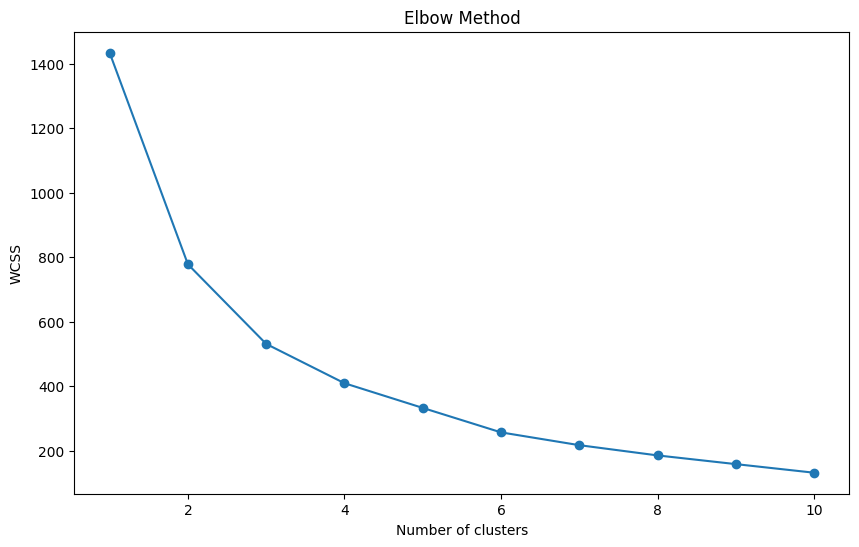

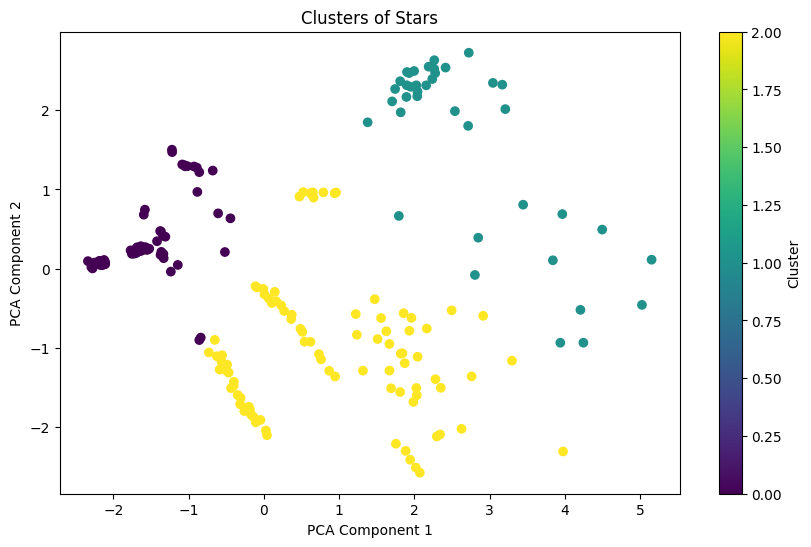

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.42      0.83      0.55        46
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00         6
           4       0.69      0.92      0.79       111
           5       0.00      0.00      0.00        40

    accuracy                           0.59       239
   macro avg       0.18      0.29      0.22       239
weighted avg       0.40      0.59      0.47       239



C:\Users\akino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\akino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\akino\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

In [97]:
# Elbow method to find the optimal number of clusters
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Applying K-means to the dataset with the optimal number of clusters from the Elbow method
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

# Add the cluster labels to the original dataframe
data['Cluster'] = y_kmeans

# PCA for 2D visualization of the clusters
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
data['PCA1'] = principal_components[:, 0]
data['PCA2'] = principal_components[:, 1]

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(data['PCA1'], data['PCA2'], c=data['Cluster'], cmap='viridis')
plt.title('Clusters of Stars')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Map clusters to the most frequent true label
# Corrected function to map clusters to the most frequent true label
def map_clusters_to_labels(data, true_label_col, cluster_col):
    labels = np.zeros_like(data[cluster_col], dtype=data[true_label_col].dtype)
    for cluster in np.unique(data[cluster_col]):
        mask = data[cluster_col] == cluster
        mode_result = mode(data.loc[mask, true_label_col])
        # Check if the mode result is a scalar and convert it to an array if necessary
        most_common_label = mode_result.mode
        if np.isscalar(most_common_label):
            most_common_label = np.array([most_common_label])
        labels[mask] = most_common_label
    return labels

# Map clusters to true labels
mapped_labels = map_clusters_to_labels(data, 'Spectral Class', 'Cluster')

# Generate classification report
print(classification_report(data['Spectral Class'], mapped_labels))

MLP

Epoch 50/50, Loss: 0.3773
MLP Accuracy (pre-tuning): 0.7916666666666666
              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       1.00      0.56      0.71         9
           2       0.50      0.25      0.33         4
           3       0.20      1.00      0.33         1
           4       0.95      0.91      0.93        22
           5       0.89      1.00      0.94         8

    accuracy                           0.79        48
   macro avg       0.67      0.74      0.64        48
weighted avg       0.86      0.79      0.80        48



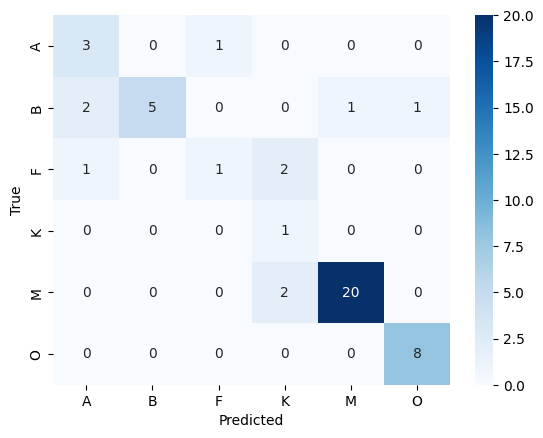

In [119]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Apply SMOTE to the training data with adjusted k_neighbors parameter
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_smote_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_smote, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the MLP model
class MLP(nn.Module):
    """
    Multi-Layer Perceptron (MLP) for classification.

    Args:
        input_dim (int): Dimension of the input features.
        
    """
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 6)  # Change to 6 classes
    
    def forward(self, x):
        """
        Forward pass of the MLP.

        Args:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train_smote_scaled.shape[1]
model = MLP(input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    """
    Train the model.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        epochs (int): Number of epochs to train. Default is 50.
    """
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Evaluate the model
def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test data.

    Args:
        model (nn.Module): Trained model.
        test_loader (DataLoader): DataLoader for the test data.
    
    Returns:
        tuple: True labels and predicted labels.
    """
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.numpy())
            y_true.extend(labels.numpy())
    return y_true, y_pred

train_model(model, train_loader, criterion, optimizer, epochs=50)
y_true, y_pred = evaluate_model(model, test_loader)

# Print evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"MLP Accuracy (pre-tuning): {accuracy}")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_spectral.classes_, yticklabels=label_encoder_spectral.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


HyperParameter Tuning for MLP

Epoch 30/30, Loss: 0.4889
Accuracy: 0.8125, Params: hidden_dim=64, dropout_rate=0.3, lr=0.001, epochs=30
Epoch 50/50, Loss: 0.3710
Accuracy: 0.75, Params: hidden_dim=64, dropout_rate=0.3, lr=0.001, epochs=50
Epoch 30/30, Loss: 0.3174
Accuracy: 0.7916666666666666, Params: hidden_dim=64, dropout_rate=0.3, lr=0.01, epochs=30
Epoch 50/50, Loss: 0.2938
Accuracy: 0.8125, Params: hidden_dim=64, dropout_rate=0.3, lr=0.01, epochs=50
Epoch 30/30, Loss: 0.6996
Accuracy: 0.75, Params: hidden_dim=64, dropout_rate=0.5, lr=0.001, epochs=30
Epoch 50/50, Loss: 0.5547
Accuracy: 0.7083333333333334, Params: hidden_dim=64, dropout_rate=0.5, lr=0.001, epochs=50
Epoch 30/30, Loss: 0.4658
Accuracy: 0.8541666666666666, Params: hidden_dim=64, dropout_rate=0.5, lr=0.01, epochs=30
Epoch 50/50, Loss: 0.4925
Accuracy: 0.8333333333333334, Params: hidden_dim=64, dropout_rate=0.5, lr=0.01, epochs=50
Epoch 30/30, Loss: 0.3295
Accuracy: 0.75, Params: hidden_dim=128, dropout_rate=0.3, lr=0.001, epochs=30
Epoch 50/50, Los

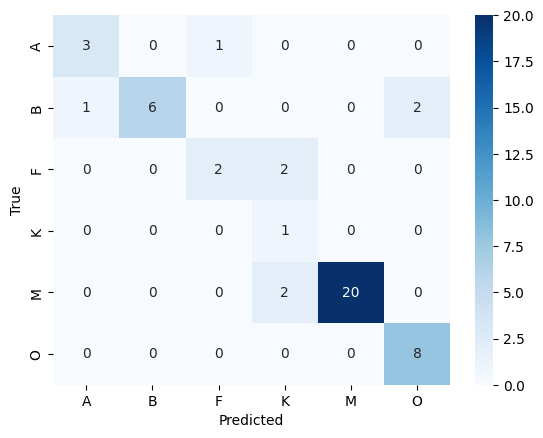

In [123]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Define the MLP model
class MLP(nn.Module):
    """
    Multi-Layer Perceptron (MLP) for classification.

    Args:
        input_dim (int): Dimension of the input features.
        hidden_dim (int): Number of neurons in the hidden layer. Default is 128.
        dropout_rate (float): Dropout rate for regularization. Default is 0.5.
    """
    def __init__(self, input_dim, hidden_dim=128, dropout_rate=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim // 2, 6)  # Change to 6 classes
    
    def forward(self, x):
        """
        Forward pass of the MLP.

        Args:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    """
    Train the model.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        epochs (int): Number of epochs to train. Default is 50.
    """
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Function to evaluate the model
def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test data.

    Args:
        model (nn.Module): Trained model.
        test_loader (DataLoader): DataLoader for the test data.
    
    Returns:
        tuple: True labels and predicted labels.
    """
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    return y_true, y_pred

# Grid search for hyperparameters
def grid_search(input_dim, param_grid, train_loader, test_loader):
    """
    Perform grid search for hyperparameter tuning.

    Args:
        input_dim (int): Dimension of the input features.
        param_grid (dict): Dictionary with hyperparameters to tune.
        train_loader (DataLoader): DataLoader for the training data.
        test_loader (DataLoader): DataLoader for the test data.
    
    Returns:
        tuple: Best hyperparameters.
    """
    best_params = None
    best_accuracy = 0.0
    
    for hidden_dim in param_grid['hidden_dim']:
        for dropout_rate in param_grid['dropout_rate']:
            for lr in param_grid['lr']:
                for epochs in param_grid['epochs']:
                    model = MLP(input_dim, hidden_dim, dropout_rate)
                    criterion = nn.CrossEntropyLoss()
                    optimizer = optim.Adam(model.parameters(), lr=lr)
                    train_model(model, train_loader, criterion, optimizer, epochs=epochs)
                    y_true, y_pred = evaluate_model(model, test_loader)
                    accuracy = accuracy_score(y_true, y_pred)
                    print(f"Accuracy: {accuracy}, Params: hidden_dim={hidden_dim}, dropout_rate={dropout_rate}, lr={lr}, epochs={epochs}")
                    
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = (hidden_dim, dropout_rate, lr, epochs)
    
    print(f"Best params: hidden_dim={best_params[0]}, dropout_rate={best_params[1]}, lr={best_params[2]}, epochs={best_params[3]}")
    return best_params

# Define the parameter grid
param_grid = {
    'hidden_dim': [64, 128],
    'dropout_rate': [0.3, 0.5],
    'lr': [0.001, 0.01],
    'epochs': [30, 50]
}

# Perform grid search
input_dim = X_train_smote_scaled.shape[1]
best_params = grid_search(input_dim, param_grid)

# Train the final model with best parameters
hidden_dim, dropout_rate, lr, epochs = best_params
model = MLP(input_dim, hidden_dim, dropout_rate)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
train_model(model, train_loader, criterion, optimizer, epochs=epochs)

# Evaluate the final model
y_true, y_pred = evaluate_model(model, test_loader)

# Print evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"MLP Accuracy (post-tuning): {accuracy}")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_spectral.classes_, yticklabels=label_encoder_spectral.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Convolutional Neural Network

Epoch 50/50, Loss: 0.1437
CNN Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       0.86      0.67      0.75         9
           2       1.00      0.50      0.67         4
           3       0.25      1.00      0.40         1
           4       1.00      0.91      0.95        22
           5       0.88      0.88      0.88         8

    accuracy                           0.83        48
   macro avg       0.76      0.83      0.73        48
weighted avg       0.90      0.83      0.85        48



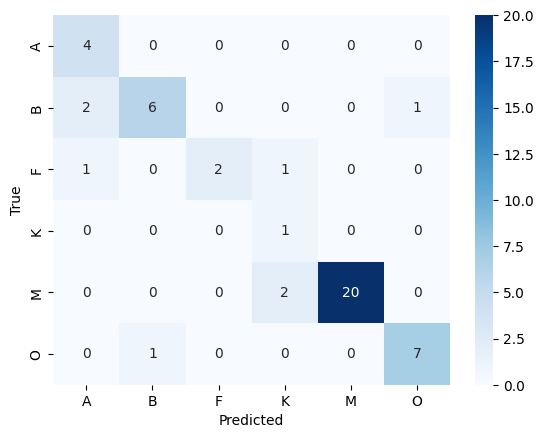

In [135]:
# Apply SMOTE to the training data with adjusted k_neighbors parameter
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Pad the feature dimension to the nearest perfect square
def pad_to_square(X):
    original_shape = X.shape[1]
    # Find the next number that is a perfect square and divisible by 4
    new_shape = int(np.ceil(np.sqrt(original_shape)))
    if new_shape % 4 != 0:
        new_shape += 4 - (new_shape % 4)
    new_shape **= 2
    padded_X = np.zeros((X.shape[0], new_shape))
    padded_X[:, :original_shape] = X
    return padded_X


X_train_smote_padded = pad_to_square(X_train_smote_scaled)
X_test_padded = pad_to_square(X_test_scaled)

# Reshape the input data to mimic an image with one channel
side_length = int(np.sqrt(X_train_smote_padded.shape[1]))
X_train_smote_reshaped = X_train_smote_padded.reshape(X_train_smote_padded.shape[0], 1, side_length, side_length)
X_test_reshaped = X_test_padded.reshape(X_test_padded.shape[0], 1, side_length, side_length)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_smote_reshaped, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_smote, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the CNN model
class CNN(nn.Module):
    """
    Convolutional Neural Network (CNN) for classification.

    Args:
        activation_func (nn.Module): Activation function to use. Default is ReLU.
        use_bn (bool): Whether to use batch normalization. Default is True.
        dropout_rate (float): Dropout rate for regularization. Default is 0.35.
    """
    def __init__(self, activation_func=nn.ReLU(), use_bn=True, dropout_rate=0.35):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if use_bn else nn.Identity()
        self.activation_func = activation_func
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64) if use_bn else nn.Identity()
        self.dropout1 = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else nn.Identity()
        self.fc1 = nn.Linear((side_length // 4) * (side_length // 4) * 64, 256)
        self.bn3 = nn.BatchNorm1d(256) if use_bn else nn.Identity()
        self.dropout2 = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()
        self.fc2 = nn.Linear(256, 6)  # Adjust the output layer to match the number of classes (6)
    
    def forward(self, x):
        """
        Forward pass of the CNN.

        Args:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation_func(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation_func(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.activation_func(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    """
    Trains a given model using the provided data loader and optimizer.
    
    Args:
        model (nn.Module): The neural network model to train.
        train_loader (DataLoader): DataLoader containing the training data.
        criterion (Loss): Loss function to optimize.
        optimizer (Optimizer): Optimization algorithm.
        epochs (int): Number of training iterations.
    """
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Evaluate the model
def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test data.

    Args:
        model (nn.Module): Trained model.
        test_loader (DataLoader): DataLoader for the test data.
    
    Returns:
        tuple: True labels and predicted labels.
    """
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.numpy())
            y_true.extend(labels.numpy())
    return y_true, y_pred

train_model(model, train_loader, criterion, optimizer, epochs=50)
y_true, y_pred = evaluate_model(model, test_loader)

# Print evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"CNN Accuracy: {accuracy}")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_spectral.classes_, yticklabels=label_encoder_spectral.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


CNN Hyperparameter Tuning

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1075       0.7500        0.7021  0.1195
      2        0.6868       0.7639        0.4993  0.0884
      3        0.5859       0.8889        0.3295  0.0734
      4        0.4612       0.8611        0.2709  0.0779
      5        0.3887       0.8889        0.2581  0.0714
      6        0.3623       0.8889        0.2276  0.0701
      7        0.3350       0.9861        0.1407  0.0755
      8        0.3663       0.9306        0.1348  0.0754
      9        0.3088       0.9306        0.1494  0.0747
     10        0.3221       0.8889        0.3009  0.0708
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2390       0.6944        0.8582  0.0764
      2        0.7296       0.7222        0.6852  0.0679
      3        0.5966       0.7083        0.6004  0.0640
      4        0.4944       0.8

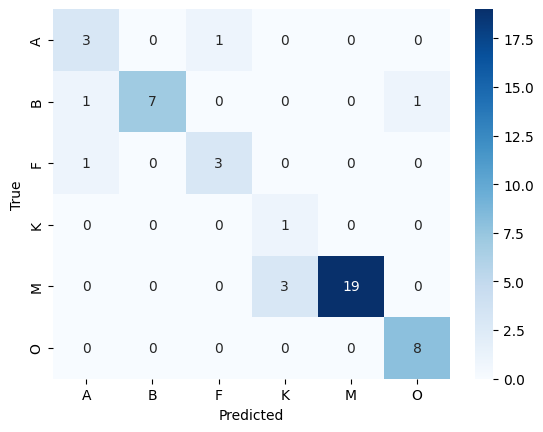

In [142]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

class CNN(nn.Module):
    """
    Convolutional Neural Network (CNN) for classification.

    Args:
        activation_func (nn.Module): Activation function to use. Default is ReLU.
        use_bn (bool): Whether to use batch normalization. Default is True.
        dropout_rate (float): Dropout rate for regularization. Default is 0.35.
    """
    def __init__(self, activation_func=nn.ReLU(), use_bn=True, dropout_rate=0.35):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32) if use_bn else nn.Identity()
        self.activation_func = activation_func
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64) if use_bn else nn.Identity()
        self.dropout1 = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else nn.Identity()
        self.fc1 = nn.Linear((side_length // 4) * (side_length // 4) * 64, 256)
        self.bn3 = nn.BatchNorm1d(256) if use_bn else nn.Identity()
        self.dropout2 = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()
        self.fc2 = nn.Linear(256, 6)  # Adjust the output layer to match the number of classes (6)
    
    def forward(self, x):
        """
        Forward pass of the CNN.

        Args:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation_func(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation_func(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn3(x)
        x = self.activation_func(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test data.

    Args:
        model (nn.Module): Trained model.
        test_loader (DataLoader): DataLoader for the test data.
    
    Returns:
        tuple: True labels and predicted labels.
    """
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            y_true.extend(target.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    return y_true, y_pred

# Instantiate the neural network classifier
net = NeuralNetClassifier(
    CNN,
    max_epochs=10,
    lr=0.01,
    batch_size=32,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Define the hyperparameters to tune
params = {
    'lr': [0.01, 0.001],
    'max_epochs': [10, 20],
    'module__dropout_rate': [0.25, 0.5],
    'optimizer__weight_decay': [0, 0.01]
}

# Perform grid search for hyperparameter tuning
gs = GridSearchCV(net, params, refit=True, cv=3, scoring='accuracy')
gs.fit(X_train_tensor, y_train_tensor)

# Evaluate the best model
best_net = gs.best_estimator_
y_true, y_pred = evaluate_model(best_net.module_, test_loader)

# Print evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"Best CNN Accuracy: {accuracy}")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder_spectral.classes_, yticklabels=label_encoder_spectral.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()